In [1]:
import matplotlib.pyplot as plt
# import os, sys
import numpy as np
from glob import glob
import pandas as pd
import warnings
from datetime import datetime, timedelta

In [2]:
warnings.filterwarnings("ignore")

In [3]:
logfiles = glob('../DTN_collate_tests/*.log')

In [4]:
logfiles

['../DTN_collate_tests/collate_no-compression_test_256_1fpf_8procs.log',
 '../DTN_collate_tests/collate_no-compression_test_34_1fpf_56procs.log',
 '../DTN_collate_tests/collate_compression_test_1024_1fpf_4procs.log',
 '../DTN_collate_tests/no-collate_no-compression_test_128_1fpf_1proc.log',
 '../DTN_collate_tests/collate_no-compression_test_256_1fpf_2procs.log',
 '../DTN_collate_tests/no-collate_no-compression_test_34_1fpf_2procs.log',
 '../DTN_collate_tests/no-collate_no-compression_test_64_1fpf_1proc.log',
 '../DTN_collate_tests/collate_compression_test_128_1fpf_32procs.log',
 '../DTN_collate_tests/collate_compression_test_34_1fpf_32procs.log',
 '../DTN_collate_tests/collate_no-compression_test_34_1fpf_2procs.log',
 '../DTN_collate_tests/no-collate_no-compression_test_128_1fpf_16procs.log',
 '../DTN_collate_tests/no-collate_no-compression_test_34_1fpf_4procs.log',
 '../DTN_collate_tests/collate_compression_test_34_1fpf_2procs.log',
 '../DTN_collate_tests/no-collate_no-compression_tes

In [5]:
logs = []
for logfile in logfiles:
    title_name = logfile.split("/")[-1].split(".")[0]
    title_cards = title_name.split("_")
    # Define the regular expression pattern to match the desired lines

    # Lists to store the extracted data
    mbps = np.nan
    sec_per_file = np.nan
    time_for_upload = np.nan
    total_MiB_uploaded = np.nan
    total_files_uploaded = np.nan
    collated = False
    compressed = False
    upload_sizes = []
    upload_times = []
    upload_speeds = []

    with open(logfile, 'r') as lf:
        for line in lf.readlines():
            #Possible lines:
            #Finished at 2024-05-29 20:38:23.761037, elapsed time = 0:00:49.929613
            #Total: 9 files; 4608.00 MiB; 92.29 MiB/s including setup time; 5.55 s/file including setup time
            if 'Finished at' in line:
                total_runtime = datetime.strptime(line.split()[-1], '%H:%M:%S.%f') - datetime(1900, 1, 1, 0, 0, 0, 0)
            elif 'Total:' in line:
                mbps = float(line.split()[5])*8
                sec_per_file = float(line.split()[10])
                total_MiB_uploaded = float(line.split()[3])
                total_files_uploaded = int(line.split()[1])
            elif 'MiB uploaded in' in line:
                upload_sizes.append(float(line.split()[0]))
                upload_times.append(timedelta(seconds = float(line.split()[4])))
                # upload_speeds.append(float(line.split()[6])) # bug in logs - calculated below
    if title_cards[0] == "collate":
        collated = True
    if title_cards[1] == "compression":
        compressed = True
    filesize_MiB = float(title_cards[3])
    n_procs = int(''.join(filter(str.isdigit,title_cards[5].split(".")[0])))
    files_per_folder = int(''.join(filter(str.isdigit,title_cards[4])))
    average_upload_time = np.mean(upload_times)

    #something wrong here - average speed appears to be double of total speed
    average_upload_speed = np.mean(np.array(upload_sizes) / (float(average_upload_time.seconds) + float(average_upload_time.microseconds)/1e6))
    mbps = total_MiB_uploaded / (float(total_runtime.seconds) + float(total_runtime.microseconds)/1e6)
    overheads_time = total_runtime - average_upload_time*total_files_uploaded
    logs.append({'Title':title_name,
                 'Transfer Speed / MiB/s':mbps,
                 'Seconds per File':sec_per_file,
                 'Original Filesize / MiB':filesize_MiB,
                 'CPU Count':n_procs,
                 'Files per Folder':files_per_folder,
                 'Average Time per Upload / s':average_upload_time,
                 'Average Speed per Upload / MiB/s':average_upload_speed,
                 'Total Time':total_runtime,
                 'Total MiB Uploaded':total_MiB_uploaded,
                 'Total Files Uploaded':total_files_uploaded,
                 'Estimated Overheads Time':overheads_time,
                 'Collated':collated,
                 'Compressed':compressed}
                 )

In [6]:
logs

[{'Title': 'collate_no-compression_test_256_1fpf_8procs',
  'Transfer Speed / MiB/s': 63.74639753891724,
  'Seconds per File': 76.3,
  'Original Filesize / MiB': 256.0,
  'CPU Count': 8,
  'Files per Folder': 1,
  'Average Time per Upload / s': datetime.timedelta(seconds=37, microseconds=690000),
  'Average Speed per Upload / MiB/s': 129.05279915096844,
  'Total Time': datetime.timedelta(seconds=76, microseconds=302351),
  'Total MiB Uploaded': 4864.0,
  'Total Files Uploaded': 1,
  'Estimated Overheads Time': datetime.timedelta(seconds=38, microseconds=612351),
  'Collated': True,
  'Compressed': False},
 {'Title': 'collate_no-compression_test_34_1fpf_56procs',
  'Transfer Speed / MiB/s': 63.5535055477927,
  'Seconds per File': 80.25,
  'Original Filesize / MiB': 34.0,
  'CPU Count': 56,
  'Files per Folder': 1,
  'Average Time per Upload / s': datetime.timedelta(seconds=39, microseconds=100000),
  'Average Speed per Upload / MiB/s': 130.43503836317134,
  'Total Time': datetime.timede

In [7]:
logs_df = pd.DataFrame(logs).sort_values(by=['Original Filesize / MiB','CPU Count','Collated','Compressed']).reset_index(drop=True)
# logs_df.drop(logs_df[logs_df['files_per_folder'] == 2].index, inplace=True)
logs_df

,Title,Transfer Speed / MiB/s,Seconds per File,Original Filesize / MiB,CPU Count,Files per Folder,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Estimated Overheads Time,Collated,Compressed
0,no-collate_no-compression_test_34_1fpf_1proc,28.932891,1.18,34.0,1,1,0 days 00:00:01.151533,29.525858,0 days 00:02:56.269978,5100.00,150,0 days 00:00:03.540028,False,False
1,collate_no-compression_test_34_1fpf_1proc,53.776724,94.84,34.0,1,1,0 days 00:00:53.630000,95.096215,0 days 00:01:34.836755,5100.01,1,0 days 00:00:41.206755,True,False
2,collate_compression_test_34_1fpf_1proc,0.149399,33.27,34.0,1,1,0 days 00:00:00.630000,7.888889,0 days 00:00:33.266685,4.97,1,0 days 00:00:32.636685,True,True
3,no-collate_no-compression_test_34_1fpf_2procs,35.955069,0.95,34.0,2,1,0 days 00:00:00.938467,36.229297,0 days 00:02:21.843700,5100.00,150,0 days 00:00:01.073650,False,False
4,collate_no-compression_test_34_1fpf_2procs,60.892681,83.75,34.0,2,1,0 days 00:00:42.270000,120.653182,0 days 00:01:23.754072,5100.01,1,0 days 00:00:41.484072,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,collate_no-compression_test_1024_1fpf_32procs,100.028926,51.19,1024.0,32,1,0 days 00:00:09.840000,520.325203,0 days 00:00:51.185194,5120.00,1,0 days 00:00:41.345194,True,False
122,collate_compression_test_1024_1fpf_32procs,0.150108,33.18,1024.0,32,1,0 days 00:00:00.960000,5.187500,0 days 00:00:33.176013,4.98,1,0 days 00:00:32.216013,True,True
123,no-collate_no-compression_test_1024_1fpf_56procs,71.373657,14.35,1024.0,56,1,0 days 00:00:14.234000,71.940424,0 days 00:01:11.735150,5120.00,5,0 days 00:00:00.565150,False,False
124,collate_no-compression_test_1024_1fpf_56procs,100.499778,50.95,1024.0,56,1,0 days 00:00:09.800000,522.448980,0 days 00:00:50.945386,5120.00,1,0 days 00:00:41.145386,True,False


DTN_test_34MiB-100GiB_1-procs_1fpf
DTN_test_34MiB-100GiB_1-procs_2fpf
DTN_test_34MiB-100GiB_4-procs_1fpf_allsubs
DTN_test_34MiB-100GiB_12-procs_1fpf_allsubs
DTN_test_64MiB-100GiB_1-procs_1fpf
DTN_test_64MiB-100GiB_2-procs_1fpf_allsubs
DTN_test_64MiB-100GiB_4-procs_1fpf_allsubs
DTN_test_64MiB-100GiB_8-procs_1fpf_allsubs
DTN_test_64MiB-100GiB_12-procs_1fpf_allsubs
DTN_test_128MiB-100GiB_1-procs_1fpf
DTN_test_256MiB-100GiB_1-procs_1fpf
DTN_test_256MiB-100GiB_4-procs_1fpf
DTN_test_512MiB-100GiB_1-procs_1fpf
DTN_test_512MiB-100GiB_4-procs_1fpf


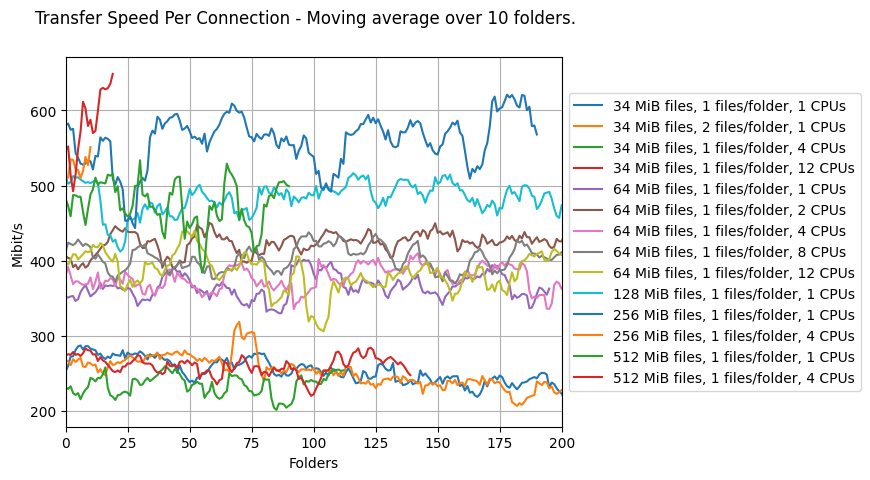

<Figure size 640x480 with 0 Axes>

In [9]:
for log in logs_df.iterrows():
    this_log = log[1]
    print(this_log['title'])
    # Create the plots
    plt.figure(1)

    # Smooth out the data by calculating the moving average
    window_size = 10
    smoothed_mib_per_sec = np.convolve(this_log['mbps'], np.ones(window_size)/window_size, mode='valid')
    smoothed_sec_per_file = np.convolve(this_log['spf'], np.ones(window_size)/window_size, mode='valid')
    plt.suptitle(f'Transfer Speed Per Connection - Moving average over {window_size} folders.')
    # Plot the smoothed data
    # plt.subplot(211)
    plt.plot(smoothed_mib_per_sec, label=f'{this_log["filesize_MiB"]:.0f} MiB files, {this_log["files_per_folder"]} files/folder, {this_log["n_procs"]} CPUs')
    plt.xlim(0, 200)
    plt.xlabel('Folders')
    plt.ylabel('Mibit/s')

    # plt.subplot(212)
    # plt.plot(smoothed_sec_per_file, label=f'{this_log["n_procs"]} procs, {this_log["files_per_folder"]} files/folder')
    # plt.xlabel('Folders')
    # plt.ylabel('s/file')

    # Add a legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.grid(True)
plt.show()
plt.tight_layout()

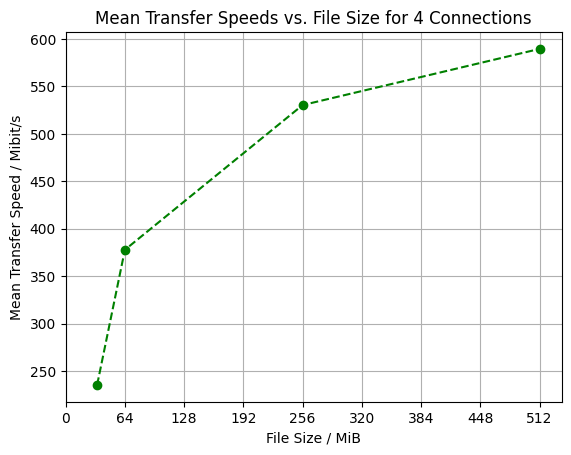

In [10]:
file_sizes = []
mean_mbps = []
# Single connection only
for log in logs_df[logs_df['n_procs'] == 4].iterrows():
    this_log = log[1]
    if this_log['files_per_folder'] != 1:
        continue

    # Extract the required columns from logs_df
    file_sizes.append(this_log['filesize_MiB'])
    mean_mbps.append(np.mean(this_log['mbps'],axis=0))

# Plot the mean transfer speeds against file size
plt.plot(file_sizes, mean_mbps, marker='o', linestyle='--', color='g')
plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('File Size / MiB')
plt.ylabel('Mean Transfer Speed / Mibit/s')
plt.title('Mean Transfer Speeds vs. File Size for 4 Connections')
plt.grid(True)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

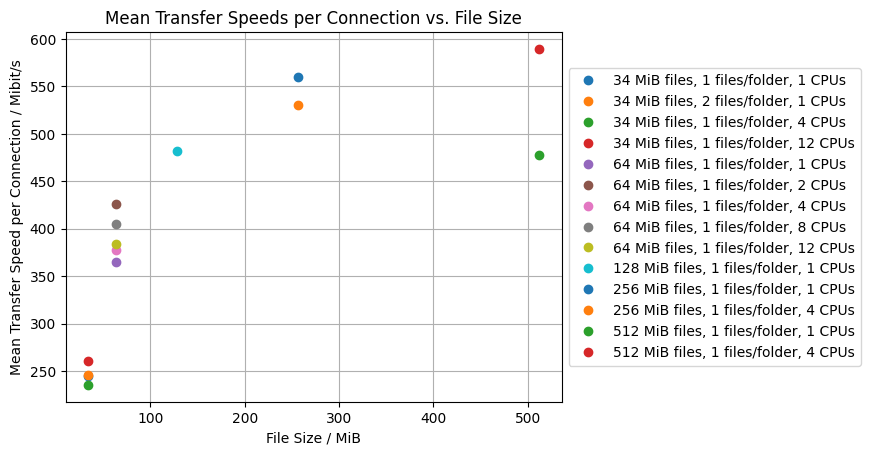

In [11]:
for log in logs_df.iterrows():
    this_log = log[1]
    #average transfer speed versus file size
    import matplotlib.pyplot as plt

    # Extract the required columns from logs_df
    file_sizes = this_log['filesize_MiB']
    mbps = this_log['mbps']

    # Calculate the mean transfer speeds in Mibit/s
    mean_mbps = np.mean(mbps, axis=0)

    # Plot the mean transfer speeds against file size
    plt.plot(file_sizes, mean_mbps, marker='o', linestyle='', label=f'{this_log["filesize_MiB"]:.0f} MiB files, {this_log["files_per_folder"]} files/folder, {this_log["n_procs"]} CPUs')
plt.xlabel('File Size / MiB')
plt.ylabel('Mean Transfer Speed per Connection / Mibit/s')
plt.title('Mean Transfer Speeds per Connection vs. File Size')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

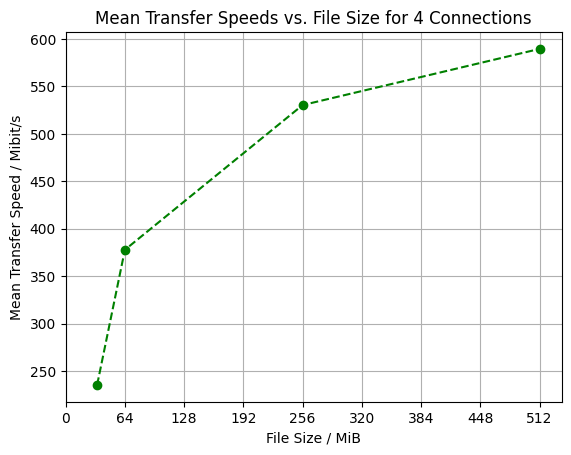

In [12]:
file_sizes = []
mean_mbps = []
# Single connection only
for log in logs_df[logs_df['n_procs'] == 4].iterrows():
    this_log = log[1]
    if this_log['files_per_folder'] != 1:
        continue

    # Extract the required columns from logs_df
    file_sizes.append(this_log['filesize_MiB'])
    mean_mbps.append(np.mean(this_log['mbps'],axis=0))

# Plot the mean transfer speeds against file size
plt.plot(file_sizes, mean_mbps, marker='o', linestyle='--', color='g')
plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('File Size / MiB')
plt.ylabel('Mean Transfer Speed / Mibit/s')
plt.title('Mean Transfer Speeds vs. File Size for 4 Connections')
plt.grid(True)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

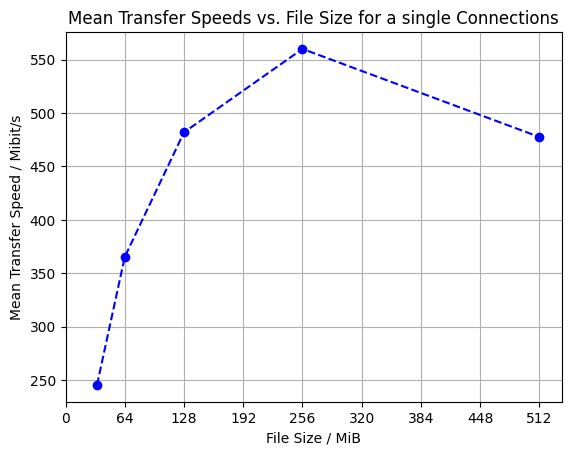

In [13]:
file_sizes = []
mean_mbps = []
# Single connection only
for log in logs_df[logs_df['n_procs'] == 1].iterrows():
    this_log = log[1]
    if this_log['files_per_folder'] != 1:
        continue

    # Extract the required columns from logs_df
    file_sizes.append(this_log['filesize_MiB'])
    mean_mbps.append(np.mean(this_log['mbps'],axis=0))

# Plot the mean transfer speeds against file size
plt.plot(file_sizes, mean_mbps, marker='o', linestyle='--', color='b')
plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('File Size / MiB')
plt.ylabel('Mean Transfer Speed / Mibit/s')
plt.title('Mean Transfer Speeds vs. File Size for a single Connections')
plt.grid(True)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

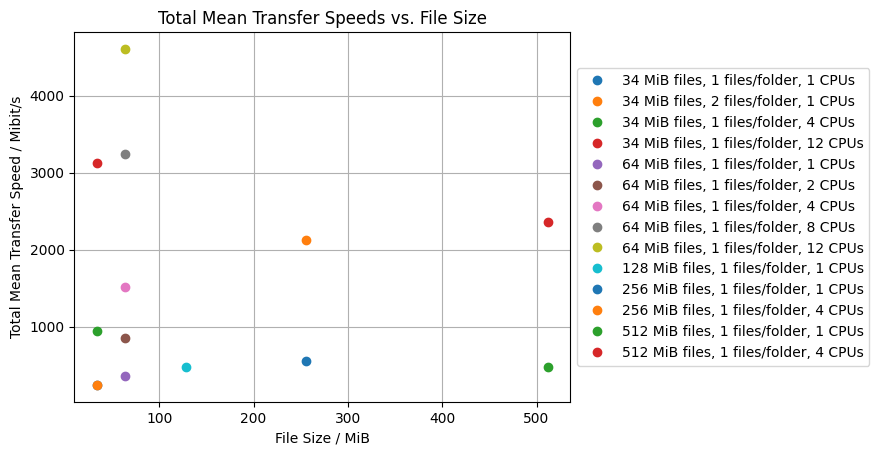

In [14]:
for log in logs_df.iterrows():
    this_log = log[1]
    #average transfer speed versus file size
    import matplotlib.pyplot as plt

    # Extract the required columns from logs_df
    file_sizes = this_log['filesize_MiB']
    mbps = this_log['mbps']
    n_procs = this_log['n_procs']

    # Calculate the mean transfer speeds in Mibit/s
    total_mean_mbps = np.mean(mbps, axis=0)*n_procs

    # Plot the mean transfer speeds against file size
    plt.plot(file_sizes, total_mean_mbps, marker='o', linestyle='', label=f'{this_log["filesize_MiB"]:.0f} MiB files, {this_log["files_per_folder"]} files/folder, {this_log["n_procs"]} CPUs')
plt.xlabel('File Size / MiB')
plt.ylabel('Total Mean Transfer Speed / Mibit/s')
plt.title('Total Mean Transfer Speeds vs. File Size')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

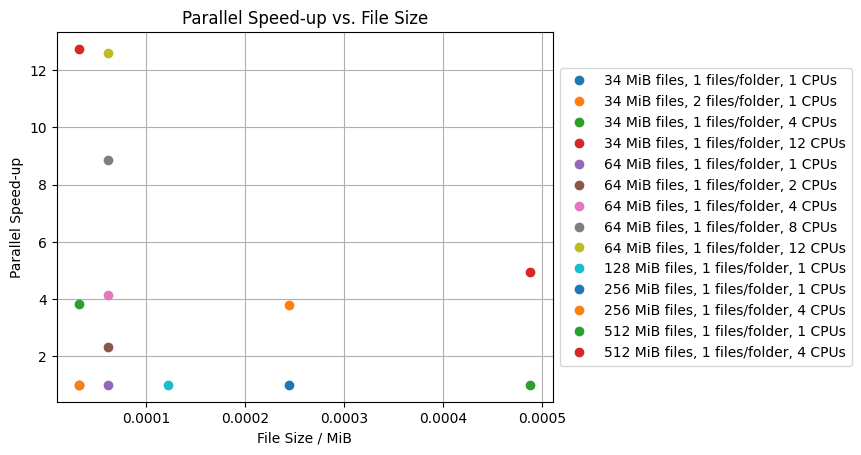

In [15]:
for log in logs_df.iterrows():
    this_log = log[1]
    #average transfer speed versus file size
    import matplotlib.pyplot as plt

    # Extract the required columns from logs_df
    file_sizes = this_log['filesize_MiB']
    mbps = this_log['mbps']
    single_cpu_mean_mbps = np.mean(logs_df[logs_df['n_procs'] == 1][logs_df['filesize_MiB'] == file_sizes]['mbps'].values[0], axis=0)
    n_procs = this_log['n_procs']

    # Calculate the mean transfer speeds in Mibit/s
    parallel_speed_up = np.mean(mbps, axis=0)*n_procs / single_cpu_mean_mbps

    # Plot the mean transfer speeds against file size
    plt.plot(file_sizes/1024**2, parallel_speed_up, marker='o', linestyle='', label=f'{this_log["filesize_MiB"]:.0f} MiB files, {this_log["files_per_folder"]} files/folder, {this_log["n_procs"]} CPUs')
plt.xlabel('File Size / MiB')
plt.ylabel('Parallel Speed-up')
plt.title('Parallel Speed-up vs. File Size')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

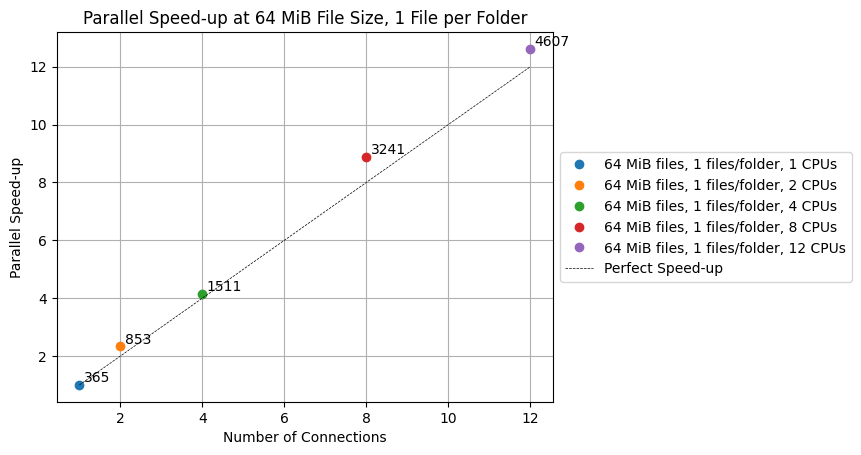

In [16]:
file_size = 64
for log in logs_df[logs_df['filesize_MiB'] == file_size].iterrows():
    this_log = log[1]
    #average transfer speed versus file size
    import matplotlib.pyplot as plt

    # Extract the required columns from logs_df
    file_sizes = this_log['filesize_MiB']
    mbps = this_log['mbps']
    single_cpu_mean_mbps = np.mean(logs_df[logs_df['n_procs'] == 1][logs_df['filesize_MiB'] == file_sizes]['mbps'].values[0], axis=0)
    n_procs = this_log['n_procs']

    # Calculate the mean transfer speeds in Mibit/s
    parallel_speed_up = np.mean(mbps, axis=0)*n_procs / single_cpu_mean_mbps
    label = f'{np.mean(mbps, axis=0)*n_procs:.0f}'
    plt.text(n_procs+0.1, parallel_speed_up+.1, label)

    # Plot the mean transfer speeds against file size
    plt.plot(n_procs, parallel_speed_up, marker='o', linestyle='', label=f'{this_log["filesize_MiB"]:.0f} MiB files, {this_log["files_per_folder"]} files/folder, {this_log["n_procs"]} CPUs')
perfect_speedup = np.linspace(1, n_procs, n_procs)
plt.plot(perfect_speedup, perfect_speedup, linestyle='--', color='black', label='Perfect Speed-up', linewidth=0.5)
plt.xlabel('Number of Connections')
plt.ylabel('Parallel Speed-up')
plt.title('Parallel Speed-up at 64 MiB File Size, 1 File per Folder')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()